## Multi-label prediction

In [1]:
%matplotlib inline
from fastai.vision import *

### Getting data

In this notebook, we'll work with the Planet Amazon dataset, which can be found on kaggle. To this end, we'll first log in to our kaggle account and 'Create New API Token' in our account page. Save the .json file in the .kaggle folder. Next, we go the planet competition, accept the rules and download the data.

In [2]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/htngu/.fastai/data/planet')

For some reason we can't download the image dataset, so I'm just gonna comment the code and download manually. Bit strange but that is for another day.

In [3]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path} 

I went and download and unzip the csv files. Anyway, train-v2 is the file we want.

In [4]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -p {path}

### The data

Let's talk a bit about the dataset. It's a dataset of satellite images of (parts of) the amazon forest. The labels can describe the atmosphere conditions as well as that of the land cover/land use, as such, each image may contain multiple labels.

In [5]:
df = pd.read_csv(path/'train_v2.csv/')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Next, we can create our data object to be fed to the model. This is one of the innovations of the fastai library. To this end, we use ImageList.from_csv() which inputs the csv file with the labels and the directory where the actual data is stored. This is like the metadata. From this we then create the image databunch.

In [6]:
transforms = get_transforms(flip_vert=True
                            , max_lighting=.1
                            , max_zoom=1.05
                            , max_warp=0.
                           )

Max_warp for perspective warping, apparently fastai is quite efficient at this. More on augmentation later.

In [7]:
source = (ImageList.from_csv(path # where to get the data
                             , 'train_v2.csv' # where do we get labels
                             , folder='train-jpg' # where is the data
                             , suffix='.jpg' 
                            )
          .split_by_rand_pct(.2) # how to split train/val
          .label_from_df(label_delim=' ') 
          # multi labels separated by space, as seen above
         )

In [8]:
data = (source.transform(transforms, size=128)
        .databunch()
        .normalize(imagenet_stats)
       )

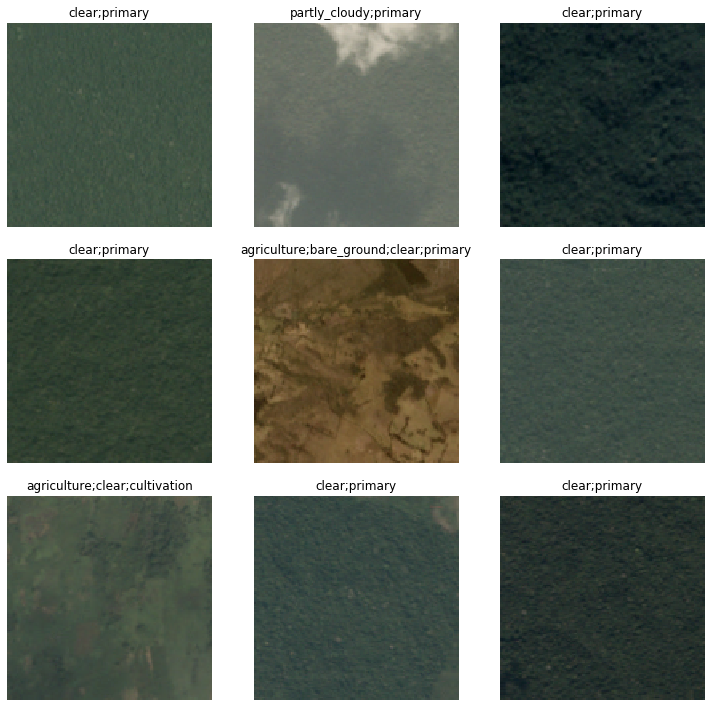

In [9]:
data.show_batch(3, figsize=(10,10))

In [10]:
data.__len__()

506

### Time for some modelling

In [11]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=.2)
f_score = partial(fbeta, thresh=.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

For the multi-label classification problem, we use the accuracy threshold instead of accuracy, because we don't just want the top-1 label. Here we predict the labels by taking the classes with corresponding proba above a threshold. Why .2 threshold in particular? It works generally ok.

The 'partial' function works like lambda x: actual_function(x, parameter). Here the parameter is the threshold.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


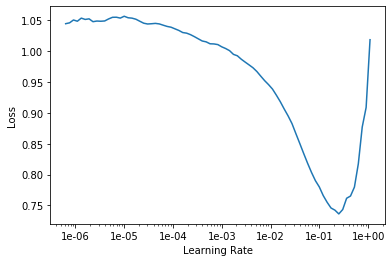

In [13]:
learn.lr_find();
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(3e-3, 3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127989,0.111814,0.950151,0.903536,03:14
1,0.117166,0.104254,0.949751,0.910812,03:09
2,0.102937,0.095694,0.958914,0.920833,03:10
3,0.093961,0.087071,0.957585,0.926559,03:09


In [17]:
learn.save('stage-1-resnet50')

This is already quite close to the top 50 of the competition at the time. Indeed with some extra learning, this can be improved to get into top 50 results.

In [13]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
learn.load('stage-1-resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: C:\Users\htngu\.fastai\data\planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary,clear;cultivation;primary,clear;primary,clear;primary,clear;primary
Path: C:\Users\htngu\.fastai\data\planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
 

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


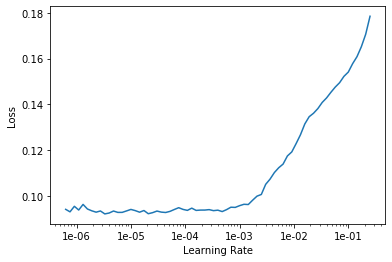

In [15]:
learn.lr_find()
learn.recorder.plot()

We note that the loss vs lr graph is quite different to when we were training only the head. Here it might be more tricky to find which lr might be suitable since there's no clear downward slope. Jeremy's rule of thumb is choose the min, max lr to be: min is 10 times smaller than the lr where the loss starts shooting up, max is a fifth of the max lr we previously used to train the head.

In [16]:
learn.fit_one_cycle(4, slice(3e-5, 3e-2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.106897,0.100199,0.942237,0.913171,03:47
1,0.100839,0.132152,0.952360,0.924126,03:46
2,0.092455,0.085773,0.956691,0.924090,03:48
3,0.089034,0.081711,0.958238,0.930075,03:46


In [17]:
learn.save('stage-2-resnet50')

Well, there you go. Fucking hell fastai.

But wait, there's more... what if we can train the model on more high-res images. So previously, we train our model on images uniformly sized at 128x128. Suppose we train instead with 256x256 images, so 4 times bigger, and also using transfer learning.

(I'm not entirely clear on this, does the input change?)

In [8]:
### my gpu is bursting at this point so I had to lower the batchsize
data = (source.transform(tfms=transforms, size=256)
        .databunch(bs=32)
        .normalize(imagenet_stats)
       )

In [9]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=.2)
f_score = partial(fbeta, thresh=.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [10]:
learn.load('stage-2-resnet50');

In [19]:
#learn.data = data

Then we can replicate the entire pipeline: freeze the arch parameters and first train the head, then unfreeze and train everything a bit more.

In [11]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


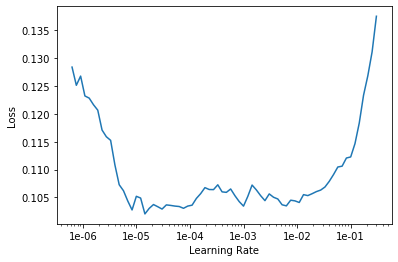

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 1e-2/2

In [13]:
learn.fit_one_cycle(4, slice(3e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101349,0.086581,0.956734,0.924310,07:08
1,0.096887,0.084414,0.958347,0.925929,07:10
2,0.095630,0.083631,0.957817,0.925953,07:06
3,0.090166,0.082551,0.958805,0.927018,07:07


In [13]:
#learn.save('stage-1-256-resnet50')
learn.load('stage-1-256-resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: C:\Users\htngu\.fastai\data\planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
partly_cloudy;primary,cloudy,agriculture;clear;cultivation;primary,haze;primary,agriculture;clear;cultivation;primary
Path: C:\Users\htngu\.fastai\data\planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


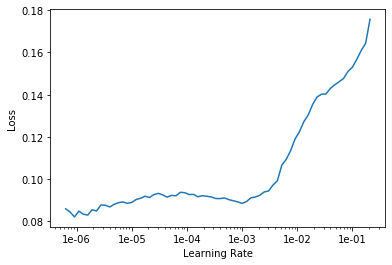

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093130,0.082347,0.958043,0.927144,09:18
1,0.088167,0.082180,0.958892,0.928347,09:23
2,0.088485,0.081752,0.959379,0.928248,09:24
3,0.089564,0.082110,0.960644,0.928416,09:22
4,0.089022,0.082151,0.959910,0.928595,09:23


In [17]:
learn.save('stage-2-256-resnet50')

Well this doesn't seem to work :/ oh well